In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
from glob import glob, iglob
import seaborn as sns
import matplotlib.pyplot as plt
from os import path

# for distance metrics
from scipy.spatial.distance import pdist, squareform
from scipy.stats import percentileofscore

In [2]:
metric='euclidean'

n_perms = 100000

In [ ]:
MOUNT_PATH = '/Users/henrymj/Documents/mounts/OAK/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel'

# Label distances

In [3]:
contrst_x_construct = pd.read_csv('X_all_newest.csv', index_col=0)
contrst_x_construct.shape

(24, 33)

In [4]:
tri_idx = np.triu_indices(len(contrst_x_construct.index), 1)

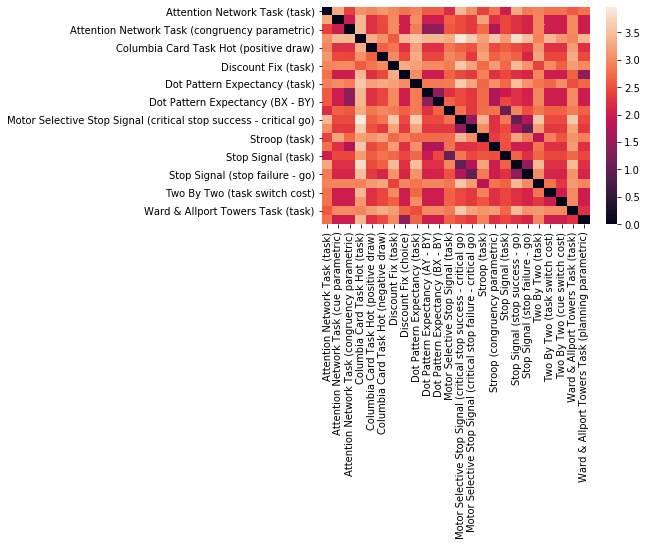

In [5]:
label_dists = squareform(pdist(contrst_x_construct.values, metric=metric))
_ = sns.heatmap(pd.DataFrame(label_dists, index=contrst_x_construct.index, columns=contrst_x_construct.index))

In [6]:
contrst_x_construct.index

Index(['Attention Network Task (task)',
       'Attention Network Task (cue parametric)',
       'Attention Network Task (congruency parametric)',
       'Columbia Card Task Hot (task)',
       'Columbia Card Task Hot (positive draw)',
       'Columbia Card Task Hot (negative draw)', 'Discount Fix (task)',
       'Discount Fix (choice)', 'Dot Pattern Expectancy (task)',
       'Dot Pattern Expectancy (AY - BY)', 'Dot Pattern Expectancy (BX - BY)',
       'Motor Selective Stop Signal (task)',
       'Motor Selective Stop Signal (critical stop success - critical go)',
       'Motor Selective Stop Signal (critical stop failure - critical go)',
       'Stroop (task)', 'Stroop (congruency parametric)', 'Stop Signal (task)',
       'Stop Signal (stop success - go)', 'Stop Signal (stop failure - go)',
       'Two By Two (task)', 'Two By Two (task switch cost)',
       'Two By Two (cue switch cost)', 'Ward & Allport Towers Task (task)',
       'Ward & Allport Towers Task (planning parametric)'

# Functional distances

In [7]:
from templateflow import api as tflow
from nilearn.input_data import NiftiLabelsMasker

In [8]:
RT_BOOL = True
PARCEL = False
ATLAS = 'Mac'

atlas_paths = {
    'Schaefer': tflow.get('MNI152NLin2009cAsym',
                  desc='400Parcels17Networks',
                  resolution=2,
                  atlas='Schaefer2018')._str,
    'Mac': '../../../fmri_data_prep/Parcels_Combo.nii.gz'
}

if PARCEL:
    masker = NiftiLabelsMasker(labels_img=atlas_paths[ATLAS], 
                               standardize=False,
                               memory='nilearn_cache',
                               verbose=0)
    def get_data(niimg_file):
        return masker.fit_transform([niimg_file])
        
else:
     def get_data(niimg_file):
        return nib.load(niimg_file).get_fdata()   

In [9]:
fancy_task_name_map = {
    'Attention Network Task': 'ANT',
    'Columbia Card Task Hot': 'CCTHot',
    'Discount Fix': 'discountFix',
    'Dot Pattern Expectancy': 'DPX',
    'Motor Selective Stop Signal': 'motorSelectiveStop',
    'Stroop': 'stroop',
    'Stop Signal': 'stopSignal',
    'Two By Two': 'twoByTwo',
    'Ward & Allport Towers Task': 'WATT3',
}

fancy_contrast_name_map = {
    'task': 'task',
    'cue parametric': 'cue_parametric',
    'congruency parametric': 'congruency_parametric',
    'positive draw': 'positive_draw',
    'negative draw': 'negative_draw',
    'choice': 'choice',
    'AY - BY': 'AY-BY',
    'BX - BY': 'BX-BY',
    'critical stop success - critical go': 'crit_stop_success-crit_go',
    'critical stop failure - critical go': 'crit_stop_failure-crit_go',
    'stop success - go': 'stop_success-go',
    'stop failure - go': 'stop_failure-go',
    'task switch cost': 'task_switch_cost',
    'cue switch cost': 'cue_switch_cost',
    'planning parametric': 'planning_parametric'
}

In [11]:
func_data = []
for task_contrast in contrst_x_construct.index:
    pieces = task_contrast.split(' (')
    task = fancy_task_name_map[pieces[0]]
    contrast = pieces[-1].replace(')', '')
    if task=='stroop' and contrast=='congruency parametric': # change in name
        contrast = 'congruency'
    else:
        contrast = fancy_contrast_name_map[contrast]
    func_data.append(get_data(path.join(MOUNT_PATH, f'{task}/secondlevel-RT-{RT_BOOL}_beta-False_maps/contrast-{contrast}_2ndlevel-intercept.nii.gz')))

In [12]:
func_arr = np.array(func_data).reshape(24, -1)
func_dists = squareform(pdist(func_arr, metric=metric))

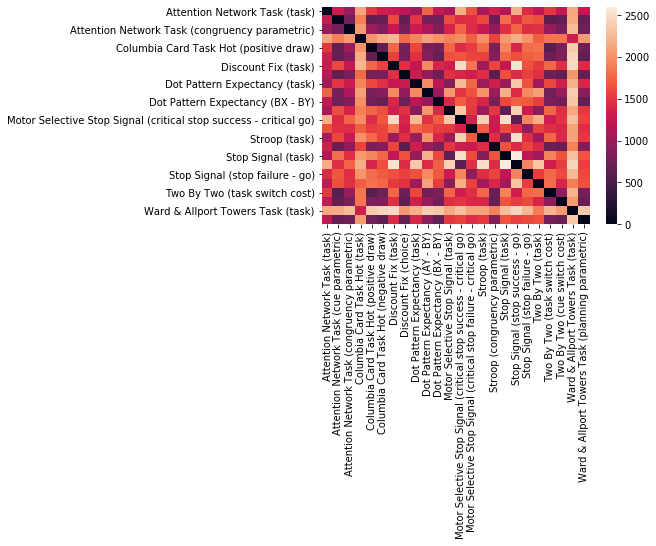

In [13]:
_ = sns.heatmap(pd.DataFrame(func_dists, index=contrst_x_construct.index, columns=contrst_x_construct.index))

# Correlate lower triangles

In [14]:
flat_label_dists = label_dists[tri_idx]
flat_func_dists = func_dists[tri_idx]

0.6050293026340884


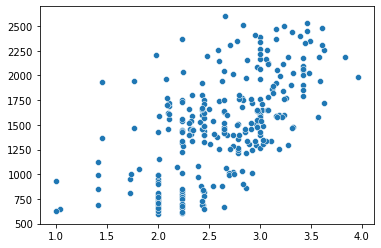

In [15]:
_ = sns.scatterplot(x=flat_label_dists, y=flat_func_dists)
main_correlation = np.corrcoef(flat_label_dists, flat_func_dists)[0, 1]
print(main_correlation)

# Comparing with old construct labels

In [16]:
contrst_x_construct_old = pd.read_csv('X_all.csv', index_col=0)
contrst_x_construct_old.shape

(24, 32)

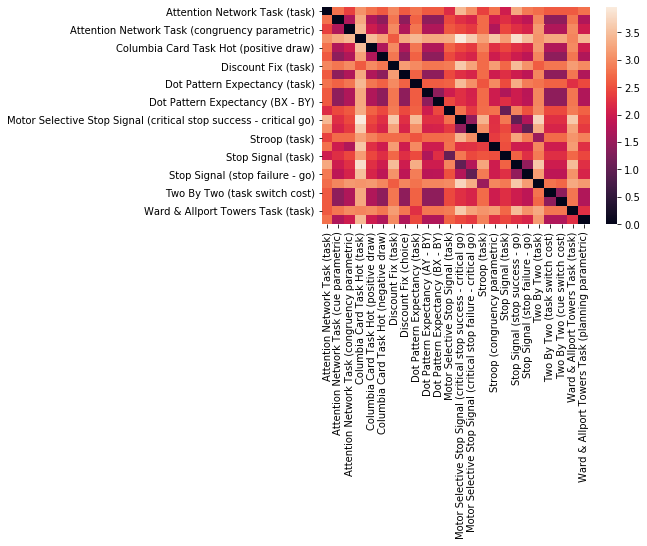

In [17]:
label_dists_old = squareform(pdist(contrst_x_construct_old.values, metric=metric))
_ = sns.heatmap(pd.DataFrame(label_dists_old, index=contrst_x_construct.index, columns=contrst_x_construct.index))

In [18]:
flat_label_dists_old = label_dists_old[tri_idx]

0.6808691794147472


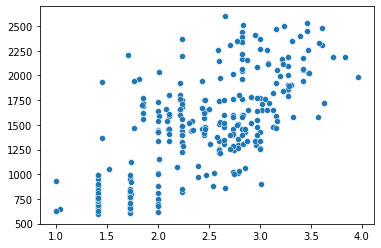

In [19]:
_ = sns.scatterplot(x=flat_label_dists_old, y=flat_func_dists)
correlation = np.corrcoef(flat_label_dists_old, flat_func_dists)[0, 1]
print(correlation)

# getting the mean absolute voxel estimate

In [20]:
mean_voxel_dict = {contr: np.nanmean(np.abs(dat)) for contr, dat in zip(contrst_x_construct.index, func_data)}
mean_voxel_dict

{'Attention Network Task (task)': 0.474620257096732,
 'Attention Network Task (cue parametric)': 0.17472552970059813,
 'Attention Network Task (congruency parametric)': 0.25375655781423384,
 'Columbia Card Task Hot (task)': 0.7556456908981682,
 'Columbia Card Task Hot (positive draw)': 0.21882338203182805,
 'Columbia Card Task Hot (negative draw)': 0.20314691479095626,
 'Discount Fix (task)': 0.5804467356336045,
 'Discount Fix (choice)': 0.17875918569514967,
 'Dot Pattern Expectancy (task)': 0.5114924581065068,
 'Dot Pattern Expectancy (AY - BY)': 0.3010905844508443,
 'Dot Pattern Expectancy (BX - BY)': 0.2052158809934197,
 'Motor Selective Stop Signal (task)': 0.5875078474243843,
 'Motor Selective Stop Signal (critical stop success - critical go)': 0.5440746766743114,
 'Motor Selective Stop Signal (critical stop failure - critical go)': 0.5360748766334406,
 'Stroop (task)': 0.5788331143989468,
 'Stroop (congruency parametric)': 0.22597989174337477,
 'Stop Signal (task)': 0.65501524743

In [21]:
abVox_dists = np.full((len(contrst_x_construct.index), len(contrst_x_construct.index)), np.nan)
for idx, contrast_i in enumerate(contrst_x_construct.index):
    for jdx, contrast_j in enumerate(contrst_x_construct.index):
        abVox_dists[idx, jdx] = np.sqrt(np.sum((mean_voxel_dict[contrast_i] - mean_voxel_dict[contrast_j])**2))

In [22]:
flat_abVox_dists = abVox_dists[tri_idx]

## correlating differnce in mean abs voxel value (x) w functional distance (y)

0.5379413280682194


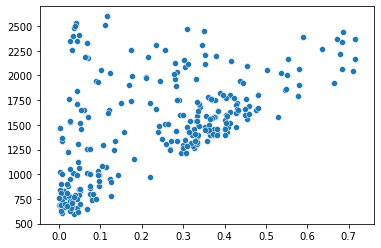

In [23]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_func_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_func_dists)[0, 1]
print(correlation)

## correlating same x with label distance (y)

0.31979506225387977


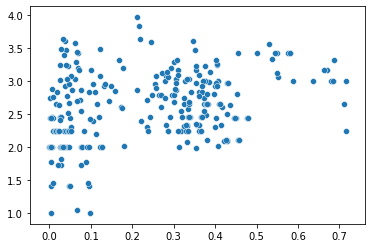

In [24]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_label_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_label_dists)[0, 1]
print(correlation)

# partial correlation between label and functional controling mean abs voxel

In [25]:
import pingouin as pg

In [26]:
distances = pd.DataFrame([flat_label_dists, flat_func_dists, flat_abVox_dists], index=['label', 'func', 'absVox']).T
distances

/Users/henrymj/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,label,func,absVox
0,3.278803,1298.259846,0.299895
1,2.397955,976.779449,0.220864
2,3.076640,2127.159386,0.281025
3,2.958172,1505.372236,0.255797
4,3.113646,1337.460789,0.271473
...,...,...,...
271,3.000213,2220.876405,0.679320
272,2.000320,766.880082,0.035947
273,3.000044,2064.733141,0.683824
274,2.000066,709.352672,0.031442


In [27]:
pg.partial_corr(data=distances, x='label', y='func', covar='absVox')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,276,0.542119,"[0.45, 0.62]",0.293893,0.28872,1.738328e-22,2.71e+19,1.0


# Repeat above using mean instead of absolute difference

In [28]:
abVox_means = np.full((len(contrst_x_construct.index), len(contrst_x_construct.index)), np.nan)
for idx, contrast_i in enumerate(contrst_x_construct.index):
    for jdx, contrast_j in enumerate(contrst_x_construct.index):
        abVox_means[idx, jdx] = np.mean([mean_voxel_dict[contrast_i], mean_voxel_dict[contrast_j]])
        
flat_abVox_dists = abVox_means[tri_idx]

0.68886455824928


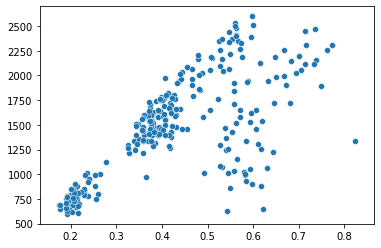

In [29]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_func_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_func_dists)[0, 1]
print(correlation)

0.4828935186535819


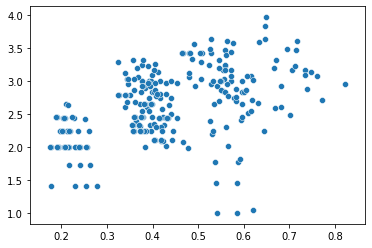

In [30]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_label_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_label_dists)[0, 1]
print(correlation)

In [31]:
distances = pd.DataFrame([flat_label_dists, flat_func_dists, flat_abVox_dists], index=['label', 'func', 'absVox']).T
distances

,label,func,absVox
0,3.278803,1298.259846,0.324673
1,2.397955,976.779449,0.364188
2,3.076640,2127.159386,0.615133
3,2.958172,1505.372236,0.346722
4,3.113646,1337.460789,0.338884
...,...,...,...
271,3.000213,2220.876405,0.550338
272,2.000320,766.880082,0.192705
273,3.000044,2064.733141,0.548086
274,2.000066,709.352672,0.190453


In [32]:
pg.partial_corr(data=distances, x='label', y='func', covar='absVox')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,276,0.429101,"[0.33, 0.52]",0.184128,0.178151,8.622232e-14,7.905e+10,1.0


## Repeat using the product instead of the mean

In [33]:
abVox_prods = np.full((len(contrst_x_construct.index), len(contrst_x_construct.index)), np.nan)
for idx, contrast_i in enumerate(contrst_x_construct.index):
    for jdx, contrast_j in enumerate(contrst_x_construct.index):
        abVox_prods[idx, jdx] = mean_voxel_dict[contrast_i] * mean_voxel_dict[contrast_j]
        
flat_abVox_dists = abVox_prods[tri_idx]

0.5166428518791923


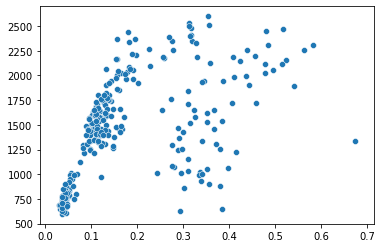

In [34]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_func_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_func_dists)[0, 1]
print(correlation)

0.38413034968051935


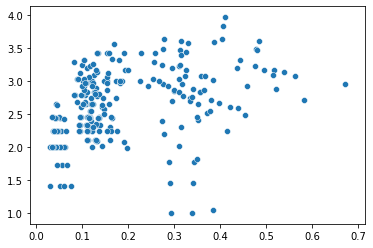

In [35]:
_ = sns.scatterplot(x=flat_abVox_dists, y=flat_label_dists)
correlation = np.corrcoef(flat_abVox_dists, flat_label_dists)[0, 1]
print(correlation)

In [36]:
distances = pd.DataFrame([flat_label_dists, flat_func_dists, flat_abVox_dists], index=['label', 'func', 'absVox']).T
distances

,label,func,absVox
0,3.278803,1298.259846,0.082928
1,2.397955,976.779449,0.120438
2,3.076640,2127.159386,0.358645
3,2.958172,1505.372236,0.103858
4,3.113646,1337.460789,0.096418
...,...,...,...
271,3.000213,2220.876405,0.187503
272,2.000320,766.880082,0.036812
273,3.000044,2064.733141,0.183495
274,2.000066,709.352672,0.036025


In [37]:
pg.partial_corr(data=distances, x='label', y='func', covar='absVox')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,276,0.514313,"[0.42, 0.6]",0.264518,0.25913,4.869839e-20,1.06e+17,1.0


# Random permutation testing

In [38]:
def permutation_test(og_arr, n_perms, inplace_shuffle_func, ref_dists=flat_func_dists, tri_idx=tri_idx):
    
    perm_corrs = np.full(n_perms, np.nan)
    for i in range(n_perms):
        shuffle_arr = og_arr.copy()
        inplace_shuffle_func(shuffle_arr)

        shuffle_dists = pdist(shuffle_arr, metric=metric)
        flattened_dists = squareform(shuffle_dists)[tri_idx]

        perm_corrs[i] = np.corrcoef(flattened_dists, ref_dists)[0, 1]
    
    return perm_corrs

## 1. Shuffle Row order in the contrast label

In [39]:
# example cell - random.shuffle swaps the row order, but nothing else
eg_arr = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

np.random.shuffle(eg_arr)
print(eg_arr)

np.random.shuffle(eg_arr)
print(eg_arr)

[[7 8 9]
 [4 5 6]
 [1 2 3]]
[[4 5 6]
 [1 2 3]
 [7 8 9]]


In [40]:
perm_corrs = permutation_test(contrst_x_construct.values.copy(), n_perms, inplace_shuffle_func=np.random.shuffle)
np.mean(perm_corrs)

0.00016798340147278318

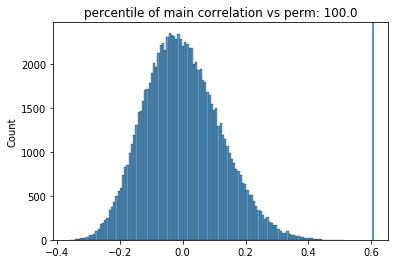

In [41]:
_ = sns.histplot(perm_corrs)
_ = plt.axvline(x=main_correlation)
_ = plt.title(f'percentile of main correlation vs perm: {percentileofscore(perm_corrs, main_correlation)}')

## 2. Shuffle each row within each column independently

In [42]:
def shuffle_within_axis(arr, axis=-1):
    np.apply_along_axis(np.random.shuffle, axis, arr)

In [43]:
# example - the row order is shuffled within each column independently
eg_arr = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

shuffle_within_axis(eg_arr, 0)
print(eg_arr)

shuffle_within_axis(eg_arr, 0)
print(eg_arr)

[[1 5 6]
 [7 2 3]
 [4 8 9]]
[[4 5 3]
 [7 2 9]
 [1 8 6]]


In [44]:
perm_corrs = permutation_test(contrst_x_construct.values.copy(), n_perms, inplace_shuffle_func=lambda x: shuffle_within_axis(x, 0))
np.mean(perm_corrs)

-0.0009491760829832592

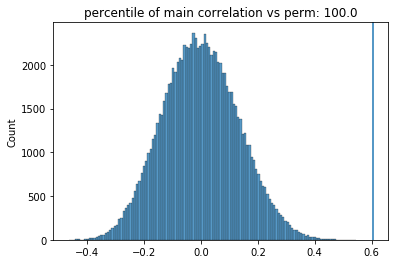

In [45]:
_ = sns.histplot(perm_corrs)
_ = plt.axvline(x=main_correlation)
_ = plt.title(f'percentile of main correlation vs perm: {percentileofscore(perm_corrs, main_correlation)}')

## 3. within each row, shuffle columns independently

In [46]:
# example - the column order is shuffled within each row independently
eg_arr = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

shuffle_within_axis(eg_arr, 1)
print(eg_arr)

shuffle_within_axis(eg_arr, 1)
print(eg_arr)

[[2 1 3]
 [6 4 5]
 [8 9 7]]
[[1 2 3]
 [4 6 5]
 [7 8 9]]


In [47]:
perm_corrs = permutation_test(contrst_x_construct.values.copy(), n_perms, inplace_shuffle_func=lambda x: shuffle_within_axis(x, 1))
np.mean(perm_corrs)

0.5023648839486262

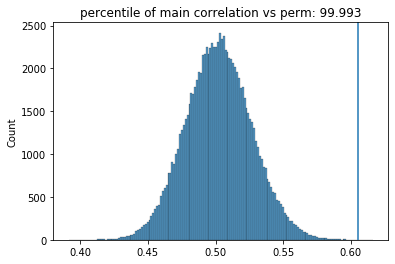

In [48]:
_ = sns.histplot(perm_corrs)
_ = plt.axvline(x=main_correlation)
_ = plt.title(f'percentile of main correlation vs perm: {percentileofscore(perm_corrs, main_correlation)}')

In [49]:
sorted(perm_corrs)[-10:]

[0.6021114048105324,
 0.60272817845326,
 0.6034898340925925,
 0.6059413658142915,
 0.6085623232543161,
 0.6101597515187409,
 0.6115146834866594,
 0.6124043909669281,
 0.6125640816161949,
 0.6163189032401449]

In [50]:
main_correlation**2

0.3660604570458913

In [51]:
np.mean(perm_corrs)**2

0.2523704766247167